# Objetivo
Este notebook tem como objetivo criar um modelo de previsão de custos de saúde utilizando o algoritmo de regressão linear. 

### Modelos
Será testado mais de um modelo, que será treinado com um conjunto de dados fictício que simula informações de pacientes e seus custos de saúde.

### Pré-requisitos
- Python 3.x
- Bibliotecas: pandas, numpy, scikit-learn, matplotlib

### Instalação de dependencias

In [1]:
# Install dependencies as needed:
! pip install kagglehub[pandas-datasets]
! pip install seaborn
! pip install scikit-learn
! pip install statsmodels

In [2]:
import pandas as pd

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "willianoliveiragibin/healthcare-insurance",
  "insurance.csv",
)

c:\Users\ric_v\OneDrive\Documentos\Dev\git-repos\IADT-Fase-1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ric_v\AppData\Local\Temp\ipykernel_13860\2509896089.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


### Análise Exploratória de Dados (AED)

utilizamos a função shape para entender o dimencionamento dos dados, ou seja, quantas linhas e colunas temos no nosso dataset.


In [4]:
df.shape

(1338, 7)

> Visualizamos 1338 linhas e 7 colunas

Damos andamento a análise utilizando a função info() para entender o tipo de dado que temos em cada coluna, e também a quantidade de valores não nulos.

In [ ]:
df.info()

Concluímos que temos 3 colunas categóricas e 3 colunas categóricas.
Nenhuma dessas colunas possui valores nulos, o que aparentemente demonstra ser uma base previamente tratada.
As colunas categóricas são:
- `sex`
- `smoker`
- `region`

As colunas qualitativas são:
- `age`
- `bmi`
- `children`

Enquanto que a coluna `charges` é a variável alvo, ou seja, o que queremos prever.

A função head() nos mostra as 5 primeiras linhas do dataset, o que nos ajuda a entender melhor os dados.

In [ ]:
df.head()

A função describe() nos dá uma visão geral dos dados numéricos, mostrando as seguintes informações:
- count – Número total de valores não nulos 
- mean – Média dos valores
- std – Desvio padrão (variação dos dados)
- min – Valor mínimo
- 25% (1º quartil) – Valor abaixo do qual estão 25% dos dados
- 50% (mediana) – Valor central dos dados
- 75% (3º quartil) – Valor abaixo do qual estão 75% dos dados
- max – Valor máximo


In [ ]:
df.describe()

Esse resultado já nos traz algumas informações interessantes, como por exemplo:
- todas as colunas numéricas possuem valores não nulos

Isso nos da segurança de que não precisamos tratar dados faltantes.

### Já sobre os dados temos as seguintes conclusões:
- A pessoa mais jovem tem 18 anos e a mais velha 64 anos, portanto o modelo não terá boa previsão de custos para crianças, adolescente e idosos. 
- O bmi (indice de massa corporal) parece representar a população americana por inteiro, com a média em 30.4.
- A maior parte dos participantes tem 1 ou nenhum filho.

Podemos também usar a função describe() para as colunas categóricas

In [ ]:
df.describe(include=['object'])


Apesar de parecer trazer pouco valor, temos uma informação interessante, que é a quantidade de valores únicos em cada coluna.
Isso nos ajuda a classificar a coluna sex e smoker como binárias, enquanto que a coluna region possui 4 valores únicos, o que nos mostra que ela é uma variável categórica nominal.

### Análise grafica das colunas categóricas
Através da biblioteca matplotlib, conseguimos gerar gráficos para visualizar melhor os dados.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(data=df, x="sex", ax=axs[0])
axs[0].set_title("Distribuição da variável `sex`")

sns.countplot(data=df, x="smoker", ax=axs[1])
axs[1].set_title("Distribuição da variável `smoker`")

sns.countplot(data=df, x="region", ax=axs[2])
axs[2].set_title("Distribuição da variável `region`")

plt.tight_layout()
plt.show()

Analisando os gráficos, podemos concluir que:
#### SEX (Genero) 
A variável `sex` está com distribuição uniforme e simétrica, pois possui uma distribuição equilibrada entre homens e mulheres, com uma leve predominância de homens.
O problema da variável `sex` estar com distribuição uniforme é que ela passa a não representar a realidade de determinadas regiões, a princípio vamos ignorar essa complexidade para viabilizar o treinamento do modelo, mas podemos explorar essa variável em relação a região em que queremos prever os custos para trazer mais acuracidade para o modelo.

#### SMOKER (Fumante)
Pode-se concluir algo similar para a variável `smoker`, a distribuição deste dado nesta amostra pode ser tendenciosa não necessariamente representando a realidade ou região em que queremos prever os custos.

#### REGION
A variável `reagion` possui uma distribuição bem equilibrada, indicando que o modelo pode ser treinado para prever custos de saúde em qualquer região dos EUA.

### Análise grafica das colunas qualitativas

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(df["age"], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Distribuição da variável `age`")

sns.histplot(df["bmi"], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Distribuição da variável `bmi`")

sns.histplot(df["children"], kde=False, ax=axs[1, 0])
axs[1, 0].set_title("Distribuição da variável `children`")

sns.histplot(df["charges"], kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Distribuição da variável `charges`")

plt.tight_layout()
plt.show()

#### AGE (Idade)
Tem uma concentração maior bem na faixa dos 20 anos o que tender a forçar o modelo a prever custos de saúde mais baixos, o que pode não representar a realidade de regiões com uma população mais idosa.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

sns.boxplot(x=df["age"], ax=axs[0, 0])
axs[0, 0].set_title("Boxplot da variável `age`")

sns.boxplot(x=df["bmi"], ax=axs[0, 1])
axs[0, 1].set_title("Boxplot da variável `bmi`")

sns.boxplot(x=df["children"], ax=axs[1, 0])
axs[1, 0].set_title("Boxplot da variável `children`")

sns.boxplot(x=df["charges"], ax=axs[1, 1])
axs[1, 1].set_title("Boxplot da variável `charges`")

plt.tight_layout()
plt.show()

# Pré-processamento de Dados

Nesta etapa transformamos as variáveis categóricas em variáveis numéricas, para poder correlacionar melhor as variáveis.

In [5]:
df_encoded = df.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder

df_encoded["sex"] = df_encoded["sex"].map({"female": 0, "male": 1})

In [7]:
from sklearn.preprocessing import LabelEncoder

df_encoded["smoker"] = df_encoded["smoker"].map({"no": 0, "yes": 1})

Após a transformação das variáveis categóricas, podemos aplicar um Mapa de correção entre todas as variáveis.

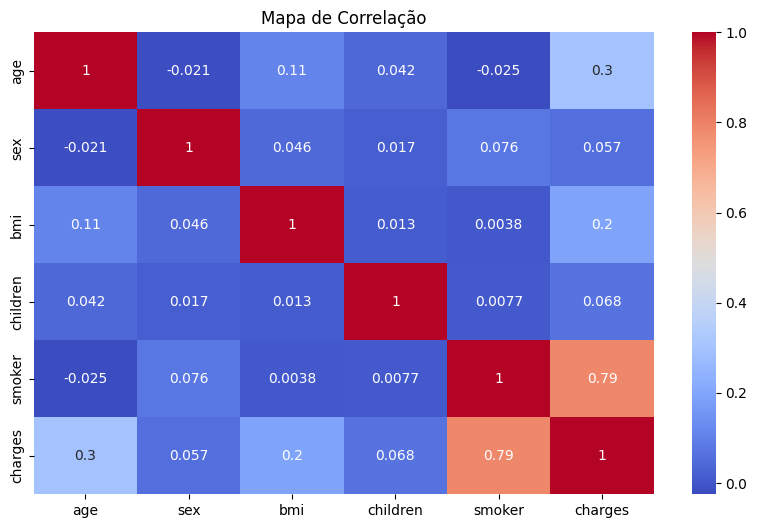

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

Apesar de correlacionar todas as variáveis o mais importante é a variável alvo, que é a `charges`, e as variáveis que mais se correlacionam com ela são:
- `smoker` (0.787)
- `age` (0.299)
- `bmi` (0.198)

Enquanto que as variáveis:
- `sex` (0.057)
- `children` (0.067)
não possuem correlação significativa com a variável alvo, o que nos leva a crer que elas não são relevantes para o modelo.

Transformação da coluna `region` em variáveis dummy, para que possamos utilizar no modelo de regressão linear.
Neste primeiro momento mantive todas as 4 variáveis para poder visualizar melhor a correlação entre elas.

In [9]:
df_encoded = pd.get_dummies(df_encoded, columns=["region"], drop_first=False)

In [10]:
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes('bool').columns})

In [11]:
df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Incluindo no mapa de correlação as variáveis dummy de região, podemos ver que a variável `region` não possui uma correlação significativa com a variável alvo, o que nos leva a crer que ela não é relevante para o modelo.

Mas ainda assim a diante pretendo acrescentar uma nova variável transformando a região em uma variável categorica numérica, que pode trazer vantagens em modelos de Arvore de Decisão.

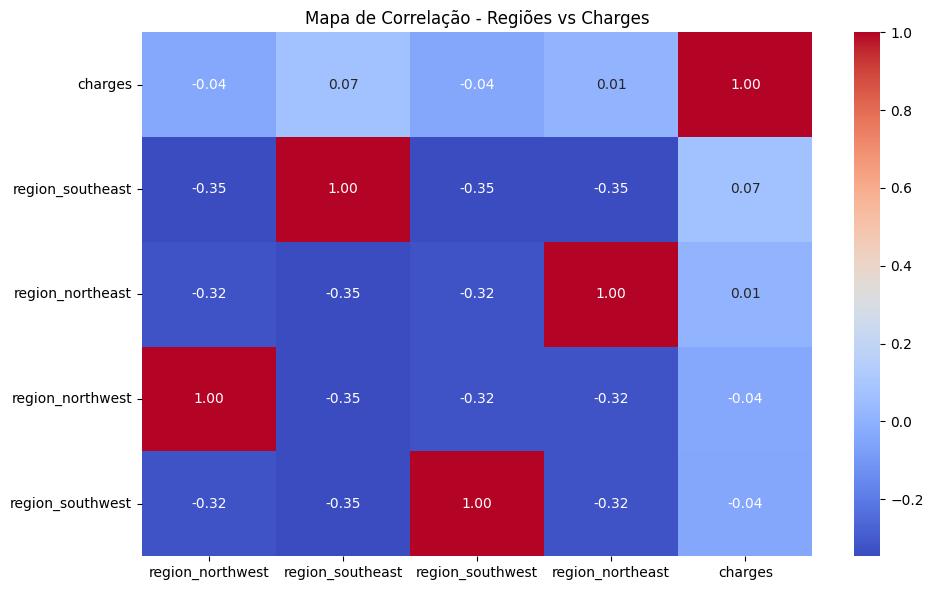

In [21]:
region_columns = [
    "region_northwest", 
    "region_southeast", 
    "region_southwest", 
    "region_northeast", 
    "charges"
]
corr_matrix = df_encoded.corr(numeric_only=True)
region_corr = corr_matrix.loc[region_columns, region_columns]  # Filter only relevant columns

plt.figure(figsize=(10, 6))
sns.heatmap(
    region_corr.sort_values(by="charges", ascending=False), 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f"
)
plt.title("Mapa de Correlação - Regiões vs Charges")
plt.tight_layout()
plt.show()

Adicionando a variável categorica de `regiao`

In [13]:
df_encoded["region_cat"] = df["region"].astype("category").cat.codes
df_encoded.head()


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,region_cat
0,19,0,27.900,0,1,16884.92400,0,0,0,1,3
1,18,1,33.770,1,0,1725.55230,0,0,1,0,2
2,28,1,33.000,3,0,4449.46200,0,0,1,0,2
3,33,1,22.705,0,0,21984.47061,0,1,0,0,1
4,32,1,28.880,0,0,3866.85520,0,1,0,0,1


Analizando a correlação da nova coluna em relação a variável alvo

# Modelagem e Treinamento

In [55]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
from sklearn.linear_model import LinearRegression

model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train_scaled, y_train)

y_pred_linear_regression = model_linear_regression.predict(X_test_scaled)

In [58]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)

y_pred_ridge = model_ridge.predict(X_test_scaled)

In [59]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=1.0)
model_lasso.fit(X_train_scaled, y_train)

y_pred_lasso = model_lasso.predict(X_test_scaled)

In [ ]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm = sm.add_constant(X_test).astype(float)
y_train_sm = y_train.astype(float)

model_ols = sm.OLS(y_train_sm, X_train_sm).fit()

y_pred_ols = model_ols.predict(X_test_sm)

# Validação Estatística

In [ ]:
import matplotlib.pyplot as plt

def grafico_de_comparacao(model, ax, y_test, y_pred):
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_xlabel("Valores Reais")
    ax.set_ylabel("Valores Previstos")
    ax.set_title(f"Previsão vs Real ({model})")
    ax.grid(True)

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

grafico_de_comparacao("Linear Regression", axs[0, 0], y_test, y_pred_linear_regression)
grafico_de_comparacao("Ridge", axs[0, 1], y_test, y_pred_ridge)
grafico_de_comparacao("Lasso", axs[1, 0], y_test, y_pred_lasso)
grafico_de_comparacao("OLS", axs[1, 1], y_test, y_pred_ols)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def avaliacao_sklearn(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return {"R²": r2, "MSE": mse, "RMSE": rmse}

pd.DataFrame({
    "Linear Regression": avaliacao_sklearn(y_test, y_pred_linear_regression),
    "Ridge": avaliacao_sklearn(y_test, y_pred_ridge),
    "Lasso": avaliacao_sklearn(y_test, y_pred_lasso),
}).T

In [ ]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def avaliacao_sklearn_kf(kf, model, X, y):
    scoring = {
        'r2': 'r2',
        'mse': 'neg_mean_squared_error'
    }

    cv_results = cross_validate(
        model, X, y,
        cv=kf,
        scoring=scoring,
        return_train_score=False
    )

    r2_scores  = cv_results['test_r2']
    mse_scores = -cv_results['test_mse']
    rmse_scores = np.sqrt(mse_scores)

    return {
        "R²": f"{r2_scores.mean():.4f} (+/- {r2_scores.std():.4f})",
        "MSE": f"{mse_scores.mean():.4f} (+/- {mse_scores.std():.4f})",
        "RMSE": f"{rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})",
    }

pd.DataFrame({
    "Linear Regression": avaliacao_sklearn_kf(kf, model_linear_regression, X, y),
    "Ridge": avaliacao_sklearn_kf(kf, model_ridge, X, y),
    "Lasso": avaliacao_sklearn_kf(kf, model_lasso, X, y),
}).T

In [ ]:
def avaliacao_statsmodels(model):
  print(model.summary())
  print(model.conf_int())

avaliacao_statsmodels(model_ols)

# Relatório

## Resultados

✅ **R² = 0.742**

Esse número mostra quanto o modelo conseguiu explicar os custos médicos com base nas informações fornecidas.

* Quanto mais perto de 1 (ou 100%), melhor o modelo está explicando os dados.
* Neste caso, o R² de 0.742 significa que 74,2% das diferenças nos custos médicos entre as pessoas podem ser previstas pelas variáveis usadas no modelo.

✅ **R² ajustado = 0.740**

Esse é um valor similar ao R², mas que leva em conta o número de variáveis usadas no modelo.

* Se o R² ajustado for muito diferente do R², pode indicar que o modelo está tentando usar variáveis desnecessárias.
* Neste caso, como o R² ajustado (0.740) é quase igual ao R² (0.742), isso mostra que as variáveis escolhidas são realmente úteis e não há problemas de *overfitting*.

✅ **F-statistic = 380.9, com p-value muito baixo (< 0.001)**

Esse teste avalia se o modelo é estatisticamente confiável.

* O p-value muito baixo significa que é quase impossível que esse resultado tenha ocorrido por acaso.
* Em outras palavras, podemos confiar no modelo como um todo.

## Validação Estatística

| Variável          | Coeficiente | p-value | Interpretação                                                  |
| ----------------- | ----------- | ------- | -------------------------------------------------------------- |
| age               | 256.98      | <0.001  | Cada ano a mais de idade aumenta, em média, \$ 256 nos custos. |
| sex               | -18.59      | 0.961   | Não tem impacto significativo.                                 |
| bmi               | 337.09      | <0.001  | Cada ponto a mais de IMC aumenta, em média, \$ 337 nos custos. |
| children          | 425.28      | 0.006   | Ter filhos está relacionado a um aumento nos custos.           |
| smoker            | 23.650      | <0.001  | Fumar aumenta os custos, em média, \$ 23.650.                  |
| region\_northwest | -370.68     | 0.490   | Não tem impacto significativo.                                 |
| region\_southeast | -657.86     | 0.223   | Não tem impacto significativo.                                 |
| region\_southwest | -809.80     | 0.131   | Não tem impacto significativo.                                 |

Somente as variáveis `age`, `bmi`, `children` e `smoker` apresentaram impacto estatisticamente significativo (p-value < 0.05).

## Insights Obtidos

* Fumar é o principal fator que aumenta os custos médicos, com um impacto médio de mais de \$ 23 mil.
* A idade e o IMC também são bons preditores dos custos médicos.
* O número de filhos tem um impacto moderado, mas é estatisticamente significativo.
* O sexo e a região não têm relevância estatística no modelo, ou seja, esses fatores não parecem influenciar diretamente os custos médicos quando consideramos as outras variáveis.

# Extra

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_random_forest_regressor = RandomForestRegressor()
model_random_forest_regressor.fit(X_train, y_train)

pd.DataFrame({
    "Random Forest Regressor": avaliacao_sklearn_kf(kf, model_random_forest_regressor, X, y)
}).T